# FUSING SPATIAL AND TEMPORAL FEATURES WITH TRANSFORMER GATES: A HYBRID DEEP LEARNING MODEL FOR INTRUSION DETECTION IN SYSTEMS

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, List, Dict, Optional, Union

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier
# Boruta
from boruta import BorutaPy

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate, Multiply, DepthwiseConv2D, MultiHeadAttention

import warnings
warnings.filterwarnings("ignore")


In [2]:
class NetworkTrafficPipeline:
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.path = None
        
    def download_dataset(self):
        self.path = kagglehub.dataset_download("dhoogla/unswnb15")
        print("Dataset downloaded to:", self.path)
        return self.path
    
    def load_data(self):
        train_data = pd.read_parquet(f"{self.path}/UNSW_NB15_training-set.parquet")
        test_data = pd.read_parquet(f"{self.path}/UNSW_NB15_testing-set.parquet")
        return train_data, test_data

In [3]:
pipeline = NetworkTrafficPipeline()

path = pipeline.download_dataset()
train_data, test_data = pipeline.load_data()
dataset = pd.concat([train_data,test_data])

Dataset downloaded to: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


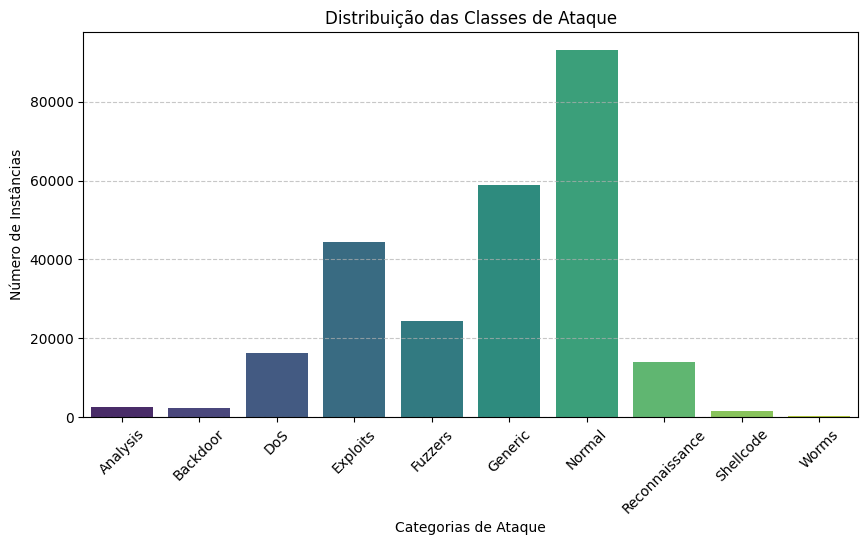

In [4]:
class_counts = dataset['attack_cat'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Categorias de Ataque")
plt.ylabel("Número de Instâncias")
plt.title("Distribuição das Classes de Ataque")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [5]:
class UNSWNB15Preprocessor:
    def __init__(self, data: pd.DataFrame, test_size: float = 0.2,
                 val_size: float = 0.1, mode: str = 'binary'):
        self.data = data.copy()
        self.test_size = test_size
        self.val_size = val_size
        self.X_train, self.X_val, self.X_test = None, None, None
        self.y_train, self.y_val, self.y_test = None, None, None
        self.selected_features = []
        self.freq_encoders = {}
        self.scaler = StandardScaler()
        self.class_weights = {}
        
        if mode not in ['binary', 'multiclass']:
            raise ValueError("Mode must be either 'binary' or 'multiclass'")
        self.mode = mode
        self.target = 'label' if mode == 'binary' else 'attack_cat'
        self.normal_label = 0

    def _split_dataset(self):
        train_val_data, test_data = train_test_split(
            self.data,
            test_size=self.test_size,
            stratify=self.data[self.target],
            random_state=42
        )

        train_data, val_data = train_test_split(
            train_val_data,
            test_size=self.val_size,
            stratify=train_val_data[self.target],
            random_state=42
        )
        
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data

    def _remove_label(self):
        other_column = 'attack_cat' if self.mode == 'binary' else 'label'
        for df in [self.train_data, self.val_data, self.test_data]:
            df.drop(columns=[other_column], errors='ignore', inplace=True)
            
    def _remove_rare_classes(self):
        if self.mode == 'multiclass':
            class_frequencies = self.train_data[self.target].value_counts(normalize=True)
            rare_classes = class_frequencies[class_frequencies < 0.05].index.tolist()
            
            if rare_classes:
                self.train_data = self.train_data[~self.train_data[self.target].isin(rare_classes)]
                self.val_data = self.val_data[~self.val_data[self.target].isin(rare_classes)]
                self.test_data = self.test_data[~self.test_data[self.target].isin(rare_classes)]

    def _handle_duplicates(self):
        features = [col for col in self.train_data.columns 
                if col not in [self.target]]
        
        def calculate_sequential_duplicate_score(df):
            df = df.copy()  
            
            is_duplicate = (df[features] == df[features].shift(1)).all(axis=1)
            group_key = (~is_duplicate).cumsum()
            
            df.loc[:, 'duplicate_score'] = df.groupby(group_key).cumcount() + 1
            return df

        self.train_data = calculate_sequential_duplicate_score(self.train_data)
        self.val_data = calculate_sequential_duplicate_score(self.val_data)
        self.test_data = calculate_sequential_duplicate_score(self.test_data)


    def _encode_categoricals(self):

        categorical_cols = ['proto', 'service', 'state']
        
        for col in categorical_cols:
            if col in self.train_data.columns:
                for df_name in ['train_data', 'val_data', 'test_data']:
                    df = getattr(self, df_name)
                    df[col] = df[col].astype(str).replace('nan', 'UNKNOWN')
                    setattr(self, df_name, df.copy()) 

                freq_map = self.train_data[col].value_counts(normalize=True)
                self.freq_encoders[col] = freq_map

                for df_name in ['train_data', 'val_data', 'test_data']:
                    df = getattr(self, df_name)
                    df = df.assign(**{f'{col}_freq': df[col].map(freq_map)})
                    df[f'{col}_freq'] = df[f'{col}_freq'].fillna(0) 
                    df = df.drop(columns=[col]) 
                    setattr(self, df_name, df)

        if self.mode == 'multiclass':
            le = LabelEncoder()
            self.train_data[self.target] = le.fit_transform(self.train_data[self.target])
            valid_labels = set(le.classes_)

            self.val_data[self.target] = self.val_data[self.target].apply(
                lambda x: x if x in valid_labels else 'UNKNOWN'
            )
            self.val_data = self.val_data[self.val_data[self.target] != 'UNKNOWN'].copy()
            self.val_data[self.target] = le.transform(self.val_data[self.target])

            self.test_data[self.target] = self.test_data[self.target].apply(
                lambda x: x if x in valid_labels else 'UNKNOWN'
            )
            self.test_data = self.test_data[self.test_data[self.target] != 'UNKNOWN'].copy()
            self.test_data[self.target] = le.transform(self.test_data[self.target])


    def _feature_engineering(self):

        eps = 1e-8 
        self.log_features = [
            'sbytes', 'dbytes', 'spkts', 'dpkts', 
            'sload', 'dload', 'dur', 'ct_src_dport_ltm'
        ]
        for df in [self.train_data, self.val_data, self.test_data]:
            for col in self.log_features:
                if col in df.columns:
                    if df[col].min() >= 0:
                        df[col] = np.log1p(df[col])

            if all(x in df.columns for x in ['sbytes', 'dbytes']):
                df['sbytes_dbytes_ratio'] = df['sbytes'] / (df['dbytes'] + eps)
            if all(x in df.columns for x in ['spkts', 'dpkts']):
                df['spkts_dpkts_ratio'] = df['spkts'] / (df['dpkts'] + eps)

            if all(x in df.columns for x in ['sloss', 'dloss', 'spkts', 'dpkts']):
                df['loss_ratio'] = (df['sloss'] + df['dloss']) / (df['spkts'] + df['dpkts'] + eps)

            if all(x in df.columns for x in ['spkts', 'dpkts']):
                df['packet_error_ratio'] = np.abs(df['spkts'] - df['dpkts']) / (df['spkts'] + df['dpkts'] + eps)

            if 'dur' in df.columns and all(x in df.columns for x in ['sbytes', 'dbytes']):
                df['throughput'] = (df['sbytes'] + df['dbytes']) / (df['dur'] + eps)
 
            if all(x in df.columns for x in ['sload', 'dload']):
                df['load_ratio'] = df['sload'] / (df['dload'] + eps)

            if all(x in df.columns for x in ['sjit', 'djit']):
                df['jitter_ratio'] = df['sjit'] / (df['djit'] + eps)

            if all(x in df.columns for x in ['stcpb', 'dtcpb']):
                df['tcp_window_ratio'] = df['stcpb'] / (df['dtcpb'] + eps)

            if all(x in df.columns for x in ['ct_src_dport_ltm', 'ct_dst_sport_ltm']):
                df['port_conn_ratio'] = df['ct_src_dport_ltm'] / (df['ct_dst_sport_ltm'] + eps)
            
            if all(x in df.columns for x in ['synack', 'ackdat']):
                df['ack_error_ratio'] = np.abs(df['synack'] - df['ackdat']) / (df['synack'] + df['ackdat'] + eps)
                

    def _prepare_data_splits(self):

        self.X_train = self.train_data.drop(self.target, axis=1)
        self.y_train = self.train_data[self.target]
        
        self.X_val = self.val_data.drop(self.target, axis=1)
        self.y_val = self.val_data[self.target]
        
        self.X_test = self.test_data.drop(self.target, axis=1)
        self.y_test = self.test_data[self.target]

    def _select_features(self):
   
        lgb = LGBMClassifier(
            n_jobs=-1,
            class_weight='balanced',
            max_depth=20, 
            n_estimators=200,  
            random_state=42,
            verbose = 0
        )
        
        boruta = BorutaPy(
            estimator=lgb,
            n_estimators='auto',
            max_iter=200,
            verbose=0,
            random_state=42,
            alpha=0.01
        )
        
        boruta.fit(self.X_train.values, self.y_train.values)
        self.selected_features = self.X_train.columns[boruta.support_].tolist()
                
        self.X_train = self.X_train[self.selected_features]
        self.X_val = self.X_val[self.selected_features]
        self.X_test = self.X_test[self.selected_features]
        
        print(f"✅ {len(self.selected_features)} features selecionadas\n")
        return self.selected_features

    def _detect_outliers(self):
        detector = IsolationForest(
            contamination=0.01,
            n_estimators=200,
            random_state=42
        )
        outliers = detector.fit_predict(self.X_train) == -1
        normal_outliers = (self.y_train == self.normal_label) & outliers
        
        self.X_train = self.X_train.loc[~normal_outliers]
        self.y_train = self.y_train.loc[~normal_outliers]

    def _scale_features(self):
        self.scaler.fit(self.X_train)
        
        self.X_train = pd.DataFrame(
            self.scaler.transform(self.X_train),
            columns=self.selected_features,
            index=self.X_train.index
        )
        
        self.X_val = pd.DataFrame(
            self.scaler.transform(self.X_val),
            columns=self.selected_features,
            index=self.X_val.index
        )
        
        self.X_test = pd.DataFrame(
            self.scaler.transform(self.X_test),
            columns=self.selected_features,
            index=self.X_test.index
        )

    def _optimize_dtypes(self):

        for df in [self.X_train, self.X_val, self.X_test]:
            df = df.astype('float32')
        
        for series in [self.y_train, self.y_val, self.y_test]:
            series = series.astype('int32')

    def _reencode_labels(self):
        le = LabelEncoder()
        self.y_train = pd.Series(le.fit_transform(self.y_train), index=self.y_train.index)
        
        self.y_val = pd.Series(le.transform(self.y_val), index=self.y_val.index)
        self.y_test = pd.Series(le.transform(self.y_test), index=self.y_test.index)


    def _preserve_feature_names(self):
        for df in [self.X_train, self.X_val, self.X_test]:
            df.columns = df.columns.astype(str)

    def _final_validation(self):
        print("Step 14/14: Validação final...")
        assert self.X_train.shape[0] == len(self.y_train), "Inconsistência treino!"
        assert self.X_val.shape[0] == len(self.y_val), "Inconsistência validação!"
        assert self.X_test.shape[0] == len(self.y_test), "Inconsistência teste!"
 
    def preprocess(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, 
                                np.ndarray, np.ndarray, np.ndarray]:

        processing_steps = [
            self._split_dataset,
            self._remove_label,
            self._remove_rare_classes,
            self._handle_duplicates,
            self._encode_categoricals,
            self._feature_engineering,
            self._prepare_data_splits,
            self._select_features,
            self._detect_outliers,
            self._scale_features,
            self._optimize_dtypes,
            self._reencode_labels,
            self._preserve_feature_names,
            self._final_validation
        ]
        
        for step in processing_steps:
            step()
        
        return (
            self.X_train.values,
            self.X_val.values,
            self.X_test.values,
            self.y_train.values,
            self.y_val.values,
            self.y_test.values
        )

In [6]:
preprocessor = UNSWNB15Preprocessor(
    data = dataset,
    mode='multiclass'
)

X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.preprocess()
selected_features = preprocessor.selected_features  
print(selected_features )

✅ 34 features selecionadas

Step 14/14: Validação final...
['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_flw_http_mthd', 'proto_freq', 'service_freq', 'sbytes_dbytes_ratio', 'spkts_dpkts_ratio', 'loss_ratio', 'packet_error_ratio', 'throughput', 'load_ratio', 'jitter_ratio', 'port_conn_ratio', 'ack_error_ratio']


In [7]:
class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        preprocessor=None,
        sequence_length: int = 5,
        min_sequence_elements: int = 3,
        batch_size: int = 32,
        stride: int = 1,
        selected_features: Optional[List[str]] = None,
        shuffle: bool = True,
        noise_level: float = 0.01,
        num_clusters: int = 10,
    ):
        super().__init__()
        self.preprocessor = preprocessor
        self.sequence_length = sequence_length
        self.min_sequence_elements = min_sequence_elements
        self.batch_size = batch_size
        self.stride = stride
        self.shuffle = shuffle
        self.noise_level = noise_level
        self.num_clusters = num_clusters

        self._initialize_features(selected_features)
        self.indices = []
        self.temporal_data = None
        self.static_data = None
        self.labels = None
        self.group_keys = None

    def _initialize_features(self, selected_features: Optional[List[str]]):
        self.temporal_features = [
            'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 
            'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt',
            'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 
            'tcprtt', 'synack', 'ackdat', 'smean', 'dmean',
            'trans_depth', 'response_body_len', 'duplicate_score',
            'sbytes_dbytes_ratio', 'spkts_dpkts_ratio'
        ]
        self.static_features = [
            'proto_freq', 'service_freq', 'state_freq',
            'ct_src_dport_ltm', 'ct_dst_sport_ltm',
            'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
            'is_sm_ips_ports'
        ]

        if selected_features:
            self.temporal_features = [f for f in self.temporal_features if f in selected_features]
            self.static_features = [f for f in self.static_features if f in selected_features]

    def prepare_data(self, X, y):
        X_np = self._convert_to_numpy(X)
        
        temporal_feature_mask = [f in self.temporal_features for f in self.preprocessor.selected_features]
        
        self.temporal_data = X_np[:, temporal_feature_mask]

        static_feature_mask = [f in self.static_features for f in self.preprocessor.selected_features]
        self.static_data = X_np[:, static_feature_mask]
        
        self.labels = y if y is not None else None

        kmeans = KMeans(n_clusters=self.num_clusters).fit(self.temporal_data)
        self.group_keys = kmeans.labels_

        self._generate_valid_indices()

    def _generate_valid_indices(self):
        self.indices = []
        unique_groups = np.unique(self.group_keys)

        for group in unique_groups:
            group_mask = self.group_keys == group
            group_indices = np.where(group_mask)[0]

            if len(group_indices) >= self.min_sequence_elements:
                num_sequences = (len(group_indices) - self.sequence_length) // self.stride + 1
                for i in range(0, num_sequences * self.stride, self.stride):
                    self.indices.append(group_indices[i:i + self.sequence_length])

        self.indices = np.array(self.indices)

    def generate_sequences_with_indices(self, X, y=None):
        self.prepare_data(X, y)

        sequences_temporal = []
        sequences_static = []
        labels = []
        valid_indices = []

        for seq_indices in self.indices:
            temporal_seq = self.temporal_data[seq_indices]
            static_feat = self.static_data[seq_indices[0]]

            if self.labels is not None:
                label = self.labels[seq_indices[-1]]
            else:
                label = None

            sequences_temporal.append(temporal_seq)
            sequences_static.append(static_feat)
            if label is not None:
                labels.append(label)
            valid_indices.append(seq_indices[-1])

        sequences = {
            'temporal': np.array(sequences_temporal),
            'static': np.array(sequences_static)
        }

        if labels:
            labels = np.array(labels)
        else:
            labels = None

        valid_indices = np.array(valid_indices)

        return sequences, labels, valid_indices

    def add_noise(self, sequences, noise_level=0.01):
        noise = np.random.normal(scale=noise_level, size=sequences.shape)
        return sequences + noise

    def add_aggregates(self, sequences):
        means = np.mean(sequences, axis=1, keepdims=True)
        maxs = np.max(sequences, axis=1, keepdims=True)
        mins = np.min(sequences, axis=1, keepdims=True)
        return np.concatenate([sequences, means, maxs, mins], axis=-1)

    def add_positional_encoding(self, sequences):
        seq_length = sequences.shape[1]
        dim = sequences.shape[2]
        positions = np.arange(seq_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, dim, 2) * -(np.log(10000.0) / dim))
        pos_enc = np.zeros((seq_length, dim))
        pos_enc[:, 0::2] = np.sin(positions * div_term)
        pos_enc[:, 1::2] = np.cos(positions * div_term)
        return sequences + pos_enc

    def generate_attention_masks(self, sequences):
        masks = np.ones((sequences.shape[0], sequences.shape[1]))
        for i, seq in enumerate(sequences):
            valid_length = np.sum(seq != 0, axis=-1)
            masks[i, valid_length:] = 0
        return masks

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        temporal_batch = pad_sequences(
            [self.temporal_data[indices] for indices in batch_indices],
            maxlen=self.sequence_length,
            padding='post',
            dtype='float32'
        )

        temporal_batch = self.add_noise(temporal_batch, self.noise_level)
        temporal_batch = self.add_aggregates(temporal_batch)
        temporal_batch = self.add_positional_encoding(temporal_batch)

        attention_masks = self.generate_attention_masks(temporal_batch)

        static_batch = np.stack([
            self.static_data[indices[0]] for indices in batch_indices
        ])

        temporal_batch = tf.convert_to_tensor(temporal_batch, dtype=tf.float32)
        static_batch = tf.convert_to_tensor(static_batch, dtype=tf.float32)
        attention_masks = tf.convert_to_tensor(attention_masks, dtype=tf.float32)

        if self.labels is not None:
            labels_batch = np.stack([
                self.labels[indices[-1]] for indices in batch_indices
            ])
            labels_batch = tf.convert_to_tensor(labels_batch)
            return {'temporal': temporal_batch, 'static': static_batch, 'attention_mask': attention_masks}, labels_batch

        return {'temporal': temporal_batch, 'static': static_batch, 'attention_mask': attention_masks}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def get_config(self) -> Dict:
        return {
            'temporal_features': self.temporal_features,
            'static_features': self.static_features,
            'temporal_input_shape': (self.sequence_length, len(self.temporal_features) + 3), 
            'static_input_shape': (len(self.static_features),)
        }
    def _convert_to_numpy(self, X):
        if isinstance(X, tf.Tensor):
            return X.numpy()
        if hasattr(X, 'values'):
            return X.values
        return np.array(X)

In [8]:
class UNSWNB15ToImage(tf.keras.layers.Layer):
    def __init__(
        self,
        preprocessor,
        image_size: Optional[Tuple[int, int]] = None,
        cache_dir: Optional[str] = None,
        noise_level: float = 0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.preprocessor = preprocessor
        self.cache_dir = cache_dir
        self.noise_level = noise_level

        self._setup_features()
        self.image_size = image_size or self._compute_optimal_size()

        self.feature_min = self.add_weight(
            name='feature_min',
            shape=(self.n_features,),
            initializer='zeros',
            trainable=False
        )
        self.feature_max = self.add_weight(
            name='feature_max',
            shape=(self.n_features,),
            initializer='ones',
            trainable=False
        )
        self.feature_ordering = self.add_weight(
            name='feature_ordering',
            shape=(self.n_features,),
            initializer=tf.keras.initializers.Constant(np.arange(self.n_features)),
            dtype=tf.int32,
            trainable=False
        )
        self.is_initialized = self.add_weight(
            name='is_initialized',
            shape=(),
            initializer='zeros',
            dtype=tf.bool,
            trainable=False
        )

        self._normalize_features = tf.function(
            self._normalize_features_impl,
            input_signature=[
                tf.TensorSpec(shape=[None, self.n_features], dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.bool)
            ]
        )
    def _dynamic_signature(self):
        return [
            tf.TensorSpec(shape=[None, self.n_features], dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.bool)
        ]
    def _setup_features(self):
        if hasattr(self.preprocessor, 'selected_features_'):
            self.selected_features = self.preprocessor.selected_features_
        elif hasattr(self.preprocessor, 'selected_features'):
            self.selected_features = self.preprocessor.selected_features
        else:
            raise AttributeError("Preprocessor must have selected_features attribute")

        self.n_features = len(self.selected_features)

    def _compute_optimal_size(self) -> Tuple[int, int]:
        n_features = float(self.n_features)
        sqrt_features = tf.math.sqrt(n_features)
        next_power_2 = tf.cast(2 ** tf.math.ceil(tf.math.log(sqrt_features) / tf.math.log(2.0)), tf.int32)
        size = tf.maximum(next_power_2, 8)
        return (int(size), int(size))

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def _update_statistics(self, features):
        current_min = tf.reduce_min(features, axis=0)
        current_max = tf.reduce_max(features, axis=0)

        self.feature_min.assign(
            tf.where(self.is_initialized,
                    tf.minimum(self.feature_min, current_min),
                    current_min)
        )
        self.feature_max.assign(
            tf.where(self.is_initialized,
                    tf.maximum(self.feature_max, current_max),
                    current_max)
        )

        if not self.is_initialized:
            features_centered = features - tf.reduce_mean(features, axis=0)
            features_std = tf.math.reduce_std(features_centered, axis=0)
            features_normalized = features_centered / (features_std + 1e-7)
            correlation = tf.matmul(features_normalized, features_normalized, transpose_a=True) / tf.cast(tf.shape(features)[0], tf.float32)
            correlation_sum = tf.reduce_sum(tf.abs(correlation), axis=1)
            ordering = tf.argsort(correlation_sum, direction='DESCENDING')

            self.feature_ordering.assign(ordering)
            self.is_initialized.assign(True)

    def _normalize_features_impl(self, features: tf.Tensor, training: bool = False) -> tf.Tensor:
        features = tf.cast(features, tf.float32)

        if training or not self.is_initialized:
            self._update_statistics(features)

        denominator = self.feature_max - self.feature_min
        denominator = tf.where(tf.equal(denominator, 0), tf.ones_like(denominator), denominator)

        normalized = (features - self.feature_min) / denominator
        return tf.clip_by_value(normalized, 0.0, 1.0)


    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def _organize_features(self, features: tf.Tensor) -> tf.Tensor:
        return tf.gather(features, self.feature_ordering, axis=1)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def _features_to_image(self, features: tf.Tensor) -> tf.Tensor:
        batch_size = tf.shape(features)[0]
        side_length = tf.cast(tf.math.ceil(tf.math.sqrt(tf.cast(self.n_features, tf.float32))), tf.int32)

        padding_size = side_length * side_length - self.n_features
        padded = tf.pad(features, [[0, 0], [0, padding_size]])
        images = tf.reshape(padded, [batch_size, side_length, side_length, 1])

        return tf.image.resize(images, self.image_size, method='bilinear', antialias=True)

    @tf.function
    def _apply_augmentations(self, images: tf.Tensor) -> tf.Tensor:
        images = tf.image.rot90(images, tf.random.uniform(shape=[], maxval=4, dtype=tf.int32))

        shift = tf.random.uniform(shape=[2], minval=-5, maxval=5, dtype=tf.int32)
        images = tf.roll(images, shift=shift, axis=[1, 2])

        return images

    def call(self, inputs: tf.Tensor, training: Optional[bool] = False) -> tf.Tensor:
        features = tf.cast(inputs, tf.float32)
        normalized = self._normalize_features(features, training)
        organized = self._organize_features(normalized)

        if training:
            noise = tf.random.normal(tf.shape(organized), mean=0.0, stddev=self.noise_level)
            organized = organized + noise

        images = self._features_to_image(organized)

        if training:
            images = self._apply_augmentations(images)

        return images

    def visualize_images(self, images: tf.Tensor, n_samples: int = 5):
        images = images.numpy()
        fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
        for i in range(n_samples):
            axes[i].imshow(images[i, :, :, 0], cmap='viridis')
            axes[i].axis('off')
        plt.show()

    def prepare_data(self, data: Union[tf.Tensor, tf.data.Dataset], batch_size: int = 32) -> tf.data.Dataset:
        if not isinstance(data, tf.data.Dataset):
            data = tf.data.Dataset.from_tensor_slices(data)
 
        return data.batch(batch_size).map(
            self.call,
            num_parallel_calls=tf.data.AUTOTUNE
        ).cache(self.cache_dir if self.cache_dir else '').prefetch(tf.data.AUTOTUNE)

    def get_config(self) -> Dict:
        config = super().get_config()
        config.update({
            'image_size': self.image_size,
            'cache_dir': self.cache_dir,
            'n_features': self.n_features,
            'noise_level': self.noise_level,
        })
        return config

In [23]:
tf.config.optimizer.set_jit(True)
class OneCycleLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        max_lr,
        steps_per_epoch,
        epochs,
        div_factor=25.0,
        final_div_factor=1e4,
        three_phase=True
    ):
        super().__init__()
        self.max_lr = tf.cast(max_lr, tf.float32)
        self.total_steps = steps_per_epoch * epochs
        self.initial_lr = self.max_lr / div_factor
        self.min_lr = self.initial_lr / final_div_factor
        self.three_phase = three_phase

        if three_phase:
            self.phase1_steps = tf.cast(int(self.total_steps * 0.3), tf.float32)
            self.phase2_steps = tf.cast(int(self.total_steps * 0.4), tf.float32)
            self.phase3_steps = tf.cast(self.total_steps - int(self.phase1_steps) - int(self.phase2_steps), tf.float32)
        else:
            self.phase1_steps = tf.cast(int(self.total_steps * 0.3), tf.float32)
            self.phase2_steps = tf.cast(self.total_steps - int(self.phase1_steps), tf.float32)
            self.phase3_steps = tf.cast(0, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        phase1_lr = self.initial_lr + (self.max_lr - self.initial_lr) * (step / self.phase1_steps)

        phase2_step = step - self.phase1_steps
        if self.three_phase:
            phase2_lr = self.max_lr
        else:
            cosine_decay = 0.5 * (1 + tf.cos(np.pi * phase2_step / self.phase2_steps))
            phase2_lr = self.initial_lr + (self.max_lr - self.initial_lr) * cosine_decay

        phase3_step = step - self.phase1_steps - self.phase2_steps
        if self.three_phase:
            cosine_decay = 0.5 * (1 + tf.cos(np.pi * phase3_step / self.phase3_steps))
            phase3_lr = self.initial_lr * cosine_decay + self.min_lr * (1 - cosine_decay)
        else:
            phase3_lr = self.initial_lr
        
        lr = tf.where(step < self.phase1_steps, phase1_lr,
             tf.where(step < (self.phase1_steps + self.phase2_steps), 
                     phase2_lr, phase3_lr))
        
        return lr

    def get_config(self):
        return {
            "max_lr": self.max_lr,
            "total_steps": self.total_steps,
            "initial_lr": self.initial_lr,
            "min_lr": self.min_lr,
            "three_phase": self.three_phase,
            "phase1_steps": self.phase1_steps,
            "phase2_steps": self.phase2_steps,
            "phase3_steps": self.phase3_steps
        }

class TransformerFusion(layers.Layer):    
    def __init__(self, dim=128, num_heads=8, dropout_rate=0.4, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        cnn_shape, lstm_shape1, lstm_shape2 = input_shape
        self.cnn_proj = layers.Dense(
            self.dim, 
            activation='swish',
            kernel_initializer='glorot_uniform',
            input_shape=(cnn_shape[-1],)
        )
        
        self.lstm_proj1 = layers.Dense(
            self.dim, 
            activation='swish',
            kernel_initializer='glorot_uniform',
            input_shape=(lstm_shape1[-1],)
        )
        
        self.lstm_proj2 = layers.Dense(
            self.dim, 
            activation='swish',
            kernel_initializer='glorot_uniform',
            input_shape=(lstm_shape2[-1],)
        )

        self.cnn_attention = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.dim // self.num_heads,
            dropout=self.dropout_rate,
            kernel_initializer='glorot_uniform'
        )
        
        self.lstm_attention = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.dim // self.num_heads,
            dropout=self.dropout_rate,
            kernel_initializer='glorot_uniform'
        )

        self.norm_cnn = layers.LayerNormalization(epsilon=1e-6)
        self.norm_lstm = layers.LayerNormalization(epsilon=1e-6)
        self.norm_cross1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm_cross2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout = layers.Dropout(self.dropout_rate)

        self.cnn_seq_proj = layers.Dense(
            self.dim * 2,
            kernel_initializer='glorot_uniform',
            input_shape=(self.dim,)
        )

        total_dim = self.dim + (2 * self.dim) + self.dim  
        self.pre_gate = layers.Dense(
            self.dim, 
            activation='swish',
            kernel_initializer='glorot_uniform',
            input_shape=(total_dim,)
        )
        
        self.gate = layers.Dense(
            self.dim, 
            activation='sigmoid',
            kernel_initializer='glorot_uniform',
            input_shape=(self.dim,)
        )
        
        self.combine = layers.Dense(
            self.dim,
            activation='swish',
            kernel_regularizer=regularizers.l2(1e-4),
            kernel_initializer='glorot_uniform',
            input_shape=(self.dim,)
        )
        
        super().build(input_shape)

    def call(self, inputs, training=None):
        if not isinstance(inputs, (list, tuple)) or len(inputs) != 3:
            raise ValueError("Expected 3 input tensors")
            
        cnn_feat, lstm_feat1, lstm_feat2 = inputs

        cnn_proj = self.norm_cnn(self.cnn_proj(cnn_feat))
        lstm_proj1 = self.norm_lstm(self.lstm_proj1(lstm_feat1))
        lstm_proj2 = self.norm_lstm(self.lstm_proj2(lstm_feat2))

        lstm_combined = tf.stack([lstm_proj1, lstm_proj2], axis=1)

        cnn_seq = self.cnn_seq_proj(cnn_proj)
        cnn_seq = tf.reshape(cnn_seq, [-1, 2, self.dim])

        cnn_as_query = tf.expand_dims(cnn_proj, axis=1)
        cnn_attended = self.cnn_attention(
            query=cnn_as_query,
            key=lstm_combined,
            value=lstm_combined
        )
        cnn_enhanced = self.norm_cross1(cnn_as_query + cnn_attended)

        lstm_attended = self.lstm_attention(
            query=lstm_combined,
            key=cnn_seq,
            value=cnn_seq
        )
        lstm_enhanced = self.norm_cross2(lstm_combined + lstm_attended)

        cnn_flat = tf.reshape(cnn_enhanced, [-1, self.dim])
        lstm_flat = tf.reshape(lstm_enhanced, [-1, 2 * self.dim])

        combined = tf.concat([cnn_flat, lstm_flat, cnn_proj], axis=-1)  

        pre_gated = self.pre_gate(combined)  
        gate_weights = self.gate(pre_gated) 
        gated = pre_gated * gate_weights  
  
        return self.combine(self.dropout(gated, training=training))

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.dim)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'dim': self.dim,
            'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config

class Model:
    def __init__(self, preprocessor, mode='multiclass'):
        if mode not in ['multiclass', 'binary']:
            raise ValueError("Mode must be either 'multiclass' or 'binary'")
            
        self.model = None
        self.history = None
        self.mode = mode
        self.preprocessor = preprocessor
        self.class_weights = None
        self.image_transformer = None
        self.image_shape = None
        self.sequence_shape = None
        self.num_classes = None
        self.pca = None

    def adaptive_se_block(self, input_tensor):
        channels = input_tensor.shape[-1]
        ratio = max(4, channels // 8)
        
        squeeze = layers.GlobalAveragePooling2D()(input_tensor)
        excitation = layers.Dense(ratio, activation='swish')(squeeze)
        excitation = layers.Dense(channels, activation='sigmoid')(excitation)
        return Multiply()([input_tensor, layers.Reshape((1, 1, channels))(excitation)])

    def multi_scale_cnn(self, input_tensor, block_index):
        base_filters = 48
        l2_reg = 1e-5 if block_index < 2 else 2e-5

        def dilated_conv(x, dilation_rate):
            x = layers.DepthwiseConv2D(
                (3,3), dilation_rate=dilation_rate,
                padding='same', depthwise_regularizer=regularizers.l2(l2_reg)
            )(x)
            x = layers.Conv2D(base_filters//3, 1)(x)
            return x

        b1 = dilated_conv(input_tensor, 1)
        b2 = dilated_conv(input_tensor, 2)
        b3 = dilated_conv(input_tensor, 3)

        b1 = self.adaptive_se_block(b1)
        b2 = self.adaptive_se_block(b2)
        b3 = self.adaptive_se_block(b3)

        fused = Concatenate()([b1, b2, b3])
        
        fused = layers.Conv2D(
            base_filters, 1, groups=4,
            kernel_regularizer=regularizers.l2(l2_reg)
        )(fused)
        
        if input_tensor.shape[-1] == base_filters:
            fused = layers.Add()([fused, input_tensor])
            
        return layers.MaxPooling2D(2)(fused)

    def build_cnn(self):
        input_layer = layers.Input(shape=self.image_shape)
        
        x = layers.Conv2D(
            64, (3,3), padding='same',
            kernel_regularizer=regularizers.l2(2e-5)
        )(input_layer)
        x = layers.BatchNormalization(epsilon=2e-5)(x)
        x = layers.Activation('swish')(x)
        x = layers.MaxPooling2D(2)(x)
        
        x = self.multi_scale_cnn(x, block_index=1)
        x = layers.SpatialDropout2D(0.3)(x)
        
        x = self.multi_scale_cnn(x, block_index=2)
        x = layers.SpatialDropout2D(0.3)(x)
        
        x = layers.Conv2D(
            96, (3,3), padding='same', dilation_rate=2,
            kernel_regularizer=regularizers.l2(2e-5)
        )(x)
        x = layers.BatchNormalization(epsilon=2e-5)(x)
        x = layers.Activation('swish')(x)
        
        attention = layers.Conv2D(
            1, (1,1), activation='sigmoid',
            kernel_initializer='glorot_normal'
        )(x)
        x = Multiply()([x, attention])
        
        return models.Model(
            inputs=input_layer,
            outputs=[
                layers.GlobalAveragePooling2D()(x),
                layers.GlobalMaxPooling2D()(x)
            ]
        )

    def build_lstm(self, lstm_units=[64, 32], dropout_rate=0.3):
        input_layer = layers.Input(shape=self.sequence_shape)
        x = input_layer
        
        for i, units in enumerate(lstm_units):
            x = layers.Bidirectional(
                layers.LSTM(units, return_sequences=True)
            )(x)
            x = layers.LayerNormalization()(x)
            x = layers.SpatialDropout1D(dropout_rate)(x)

        def se_block_1d(input_tensor):
            channels = input_tensor.shape[-1]
            squeeze = layers.GlobalAveragePooling1D()(input_tensor)
            excitation = layers.Dense(max(4, channels // 16), activation='swish')(squeeze)
            excitation = layers.Dense(channels, activation='sigmoid')(excitation)
            return layers.Multiply()([input_tensor, layers.Reshape((1, channels))(excitation)])
        
        x = se_block_1d(x)  
        
        feature1 = layers.GlobalAveragePooling1D()(x)
        feature2 = layers.GlobalMaxPooling1D()(x)
        
        return models.Model(inputs=input_layer, outputs=[feature1, feature2])
    def _build_model(self, num_classes,steps_per_epoch,epochs):
        self.num_classes = num_classes

        input_cnn = layers.Input(shape=self.image_shape)
        input_lstm = layers.Input(shape=self.sequence_shape)
 
        cnn_model = self.build_cnn()
        lstm_model = self.build_lstm()
        
        cnn_outputs = cnn_model(input_cnn)
        lstm_outputs = lstm_model(input_lstm)

        fused_features = []
        fusion_layer = TransformerFusion()
        fusion_layer = TransformerFusion()
        for cnn_feat in cnn_outputs:
            fused = fusion_layer([cnn_feat, lstm_outputs[0], lstm_outputs[1]])
            fused = layers.LayerNormalization(epsilon=1e-6)(fused) 
            fused_features.append(fused)

        z = layers.Concatenate()(fused_features)
        z = layers.LayerNormalization(epsilon=1e-6)(z)
        z = layers.Dense(128, activation='swish')(z)
        z = layers.BatchNormalization()(z)
        z = layers.Dropout(0.4)(z)
        
        z = layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(z)
        z = layers.BatchNormalization()(z)
        z = layers.Dropout(0.3)(z)

        if self.mode == 'binary':
            output = layers.Dense(1, activation='sigmoid')(z)
            loss = tf.keras.losses.BinaryFocalCrossentropy(name='loss',label_smoothing=0.2)

        else:
            output = layers.Dense(num_classes, activation='softmax')(z)
            loss = tf.keras.losses.CategoricalFocalCrossentropy(name='loss',label_smoothing=0.2)

        self.model = models.Model(inputs=[input_cnn, input_lstm], outputs=output)

        lr_schedule = OneCycleLR(
            max_lr=1e-4,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            div_factor=10.0,
            final_div_factor=1e3,
            three_phase=False
        )
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=1e-4,         
            beta_1=0.9,
            beta_2=0.95,
            global_clipnorm=1.0        
        )
        metrics = [
            'accuracy',
            tf.keras.metrics.AUC(name='auc')
        ]

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )


    def prepare_data(self, X, y, preprocessor):
        X_np = self._convert_to_numpy(X)
        y_np = self._convert_to_numpy(y) if y is not None else None

        if self.image_transformer is None:
            self.image_transformer = UNSWNB15ToImage(preprocessor)

        sequence_generator = SequenceGenerator(
            preprocessor=preprocessor,
            sequence_length=5,
            selected_features=preprocessor.selected_features
        )
        
        sequences, labels, valid_indices = sequence_generator.generate_sequences_with_indices(X_np, y_np)
        X_sequences = sequences['temporal']
        
        X_valid = X_np[valid_indices]
        X_images = self.image_transformer(X_valid).numpy()
        
        self.image_shape = X_images.shape[1:]
        self.sequence_shape = X_sequences.shape[1:]
        self.original_labels = labels.copy() if y is not None else None
        
        if y is not None:
            if self.mode == 'multiclass':
                num_classes = len(np.unique(labels))
                labels = to_categorical(labels, num_classes=num_classes)
            else:
                labels = labels.reshape(-1, 1)
        
        return {
            'images': X_images,
            'sequences': X_sequences,
            'labels': labels
        }


    def _convert_to_numpy(self, X):
        if isinstance(X, tf.Tensor):
            return X.numpy()
        if hasattr(X, 'values'):
            return X.values
        return np.array(X)

    def train(self, X_train, y_train, X_val, y_val, preprocessor,
          batch_size=1024, epochs=100, use_class_weights=True):

        train_data = self.prepare_data(X_train, y_train, preprocessor)
        val_data = self.prepare_data(X_val, y_val, preprocessor)

        num_classes = 1 if self.mode == 'binary' else len(np.unique(self.original_labels))
        steps_per_epoch = len(train_data['images']) // batch_size
        if len(train_data['images']) % batch_size != 0:
            steps_per_epoch += 1

        self._build_model(num_classes, steps_per_epoch, epochs) 

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='auc', patience=10, mode='max', restore_best_weights=True
            ),
        ]

        history = self.model.fit(
            x=[train_data['images'], train_data['sequences']],
            y=train_data['labels'],
            batch_size=batch_size,
            validation_data=([val_data['images'], val_data['sequences']], val_data['labels']),
            epochs=epochs,
            callbacks=callbacks,
            class_weight=self.class_weights if use_class_weights else None
        )
        return history

    def compute_class_weights(y):
        y = np.argmax(y, axis=1) if y.ndim > 1 else y
        classes = np.unique(y)
        class_weights = compute_class_weight('balanced', classes=classes, y=y)
        return dict(enumerate(class_weights))

    def evaluate(self, X_test, y_test, return_predictions=False):
        test_data = self.prepare_data(X_test, y_test, self.preprocessor)
        y_true = test_data['labels']
        y_pred_proba = self.model.predict([test_data['images'], test_data['sequences']])

        if self.mode == 'multiclass':
            if y_true.ndim > 1 and y_true.shape[1] > 1:
                y_true = np.argmax(y_true, axis=1)
            y_pred = np.argmax(y_pred_proba, axis=1)
        else: 
            y_true = y_true.flatten()
            y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        report = classification_report(y_true, y_pred, output_dict=True)
        cm = confusion_matrix(y_true, y_pred)
        
        results = {
            'accuracy': acc,
            'f1_score': f1,
            'classification_report': report,
            'confusion_matrix': cm
        }
        
        if return_predictions:
            results['predictions'] = y_pred
        
        return results

        
    def display_results(self, results):

        print("\n=== Métricas Principais ===")
        print(f"Acurácia: {results['accuracy']:.4f}")
        print(f"F1-Score: {results['f1_score']:.4f}")
        
        plt.figure(figsize=(10, 10))
        cm = results['confusion_matrix']

        if self.mode == 'multiclass':
            num_classes = cm.shape[0]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=range(num_classes),
                       yticklabels=range(num_classes))
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['0', '1'],
                       yticklabels=['0', '1'])
            
        plt.title('Matriz de Confusão')
        plt.ylabel('Valor Real')
        plt.xlabel('Valor Predito')
        plt.tight_layout()
        plt.show()

    def plot_training_history(self, history):
        if not history or not hasattr(history, 'history'):
            print("Histórico de treinamento vazio ou inválido.")
            return

        metrics = [key for key in history.history.keys() if not key.startswith("val_")]

        plt.figure(figsize=(60, 20))
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, len(metrics), i+1)
            plt.plot(history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in history.history:
                plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.xlabel("Epochs")
            plt.ylabel(metric)
            plt.legend()
            plt.title(metric)

        plt.show()
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")
        pred_data = self.prepare_data(X, y=None, preprocessor=self.preprocessor)
        
        predictions = self.model.predict([pred_data['images'], pred_data['sequences']])

        if self.mode == 'multiclass':
            return np.argmax(predictions, axis=1)
        else:
            return (predictions > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")
            
        pred_data = self.prepare_data(X, y=None, preprocessor=self.preprocessor)
        predictions = self.model.predict([pred_data['images'], pred_data['sequences']])
        
        if self.mode == 'binary':
            return np.column_stack([1 - predictions, predictions])
        
        return predictions 

In [25]:
model = Model(mode='multiclass',preprocessor=preprocessor)
history = model.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    preprocessor=preprocessor,
    batch_size=128,
    epochs=50,
)


Epoch 1/50
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 217s 129ms/step - accuracy: 0.2599 - auc: 0.5969 - loss: 0.5351 - val_accuracy: 0.6312 - val_auc: 0.8715 - val_loss: 0.3308
Epoch 2/50
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 179s 127ms/step - accuracy: 0.4222 - auc: 0.7426 - loss: 0.3941 - val_accuracy: 0.6815 - val_auc: 0.9330 - val_loss: 0.2605
Epoch 3/50
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 182s 129ms/step - accuracy: 0.5367 - auc: 0.8393 - loss: 0.2998 - val_accuracy: 0.7022 - val_auc: 0.9389 - val_loss: 0.2288
Epoch 4/50
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 179s 127ms/step - accuracy: 0.6117 - auc: 0.8932 - loss: 0.2485 - val_accuracy: 0.7252 - val_auc: 0.9496 - val_loss: 0.2087
Epoch 5/50
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 180s 127ms/step - accuracy: 0.6615 - auc: 0.9160 - loss: 0.2248 - val_accuracy: 0.7537 - val_auc: 0.9577 - val_loss: 0.1919
Epoch 6/50
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 180s 128ms/step - accuracy: 0.6982 - auc: 0.9318 - loss: 0.2085 - val_accuracy: 0.7648 - val_auc: 0.9626 - val_loss: 0.1812
Epoc

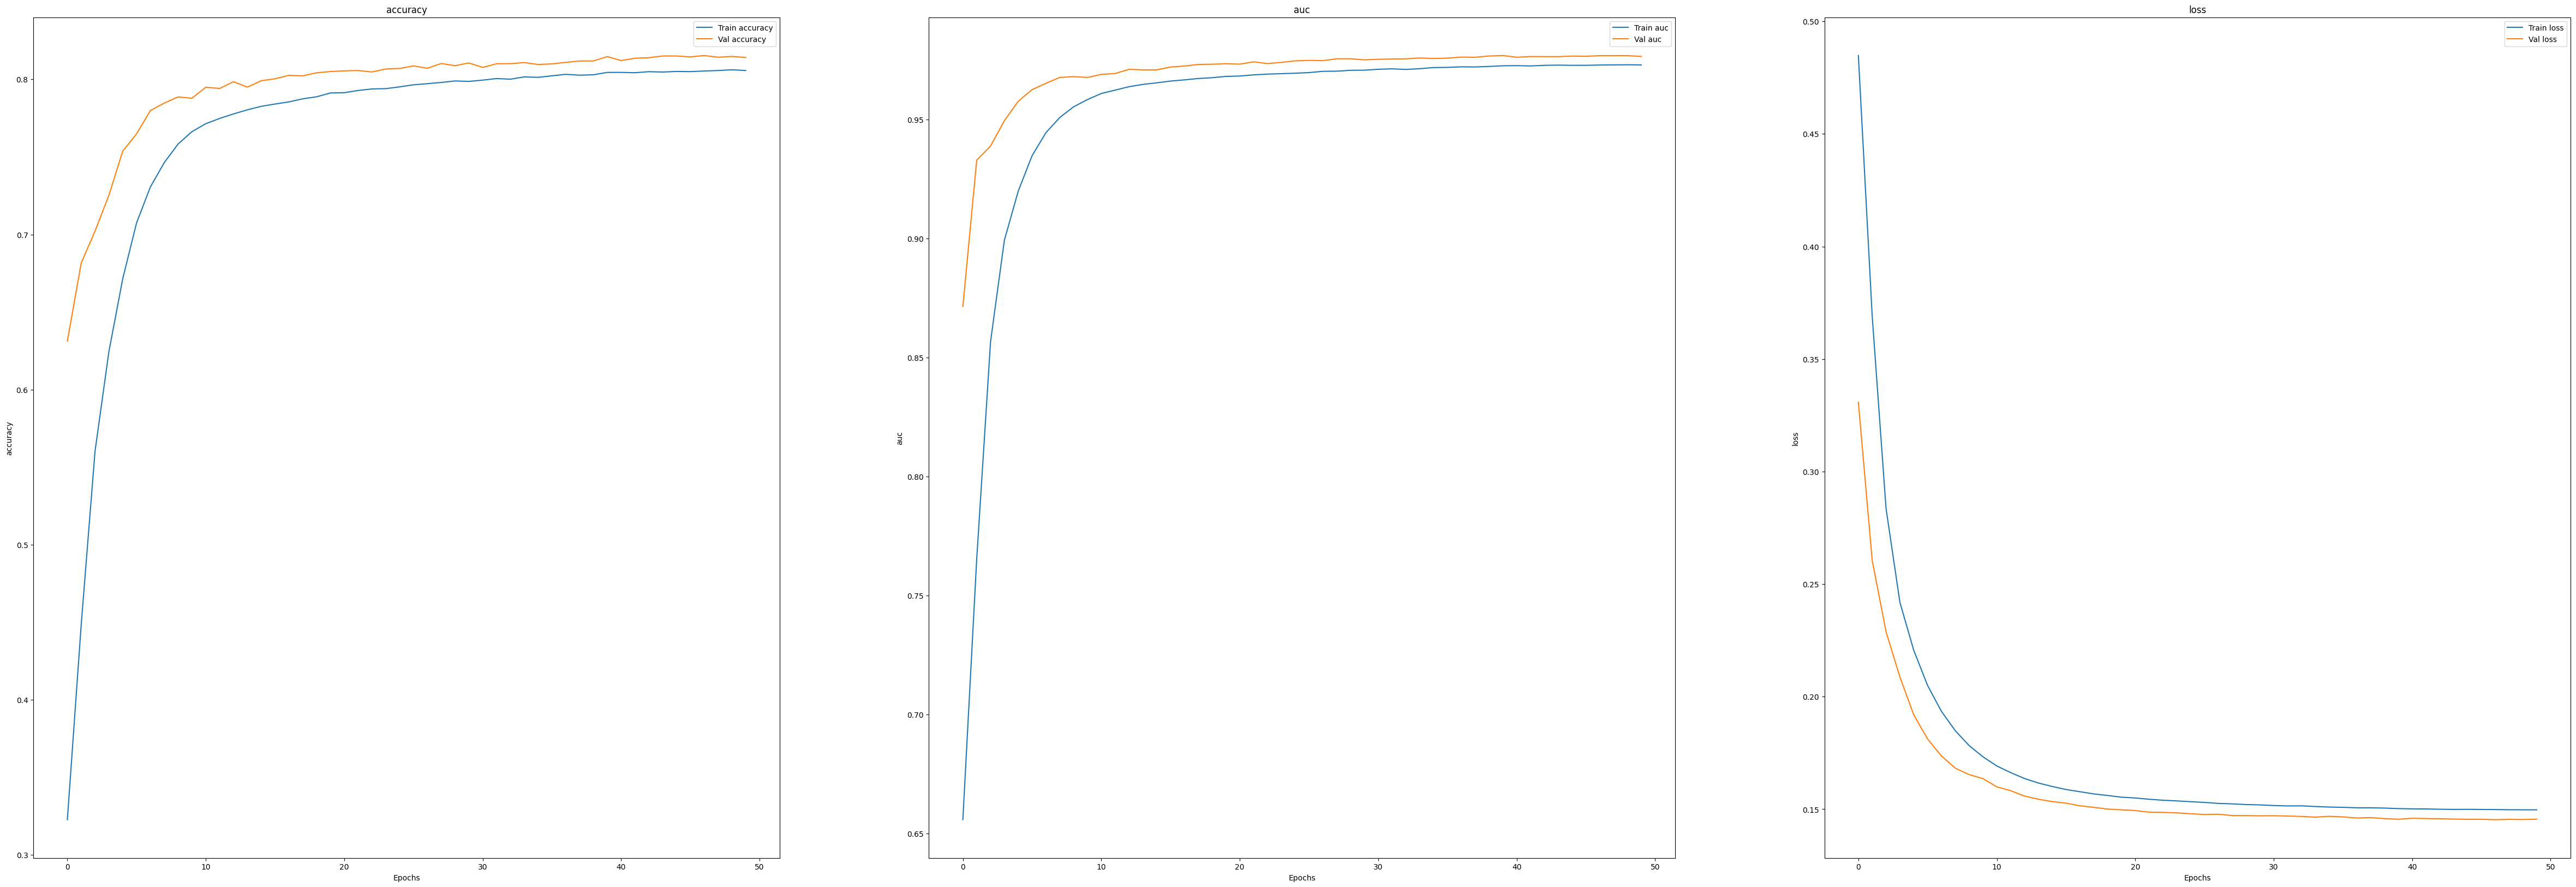

In [26]:
model.plot_training_history(history)

In [27]:
preprocessor_bin = UNSWNB15Preprocessor(
    data = dataset,
    mode='binary'
)

X_train_bin, X_val_bin, X_test_bin, y_train_bin, y_val_bin, y_test_bin = preprocessor_bin.preprocess()
selected_features = preprocessor.selected_features  
print(selected_features )

✅ 38 features selecionadas

Step 14/14: Validação final...
['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_flw_http_mthd', 'proto_freq', 'service_freq', 'sbytes_dbytes_ratio', 'spkts_dpkts_ratio', 'loss_ratio', 'packet_error_ratio', 'throughput', 'load_ratio', 'jitter_ratio', 'port_conn_ratio', 'ack_error_ratio']


In [28]:
model_bin = Model(mode='binary',preprocessor=preprocessor_bin)
model_bin.image_transformer = UNSWNB15ToImage(preprocessor_bin)
history_bin = model_bin.train(
    X_train=X_train_bin,
    y_train=y_train_bin,
    X_val=X_val_bin,
    y_val=y_val_bin,
    preprocessor=preprocessor_bin,
    batch_size=128,
    epochs=25,
    use_class_weights=None
)

Epoch 1/25
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 241s 145ms/step - accuracy: 0.6033 - auc: 0.6453 - loss: 0.3477 - val_accuracy: 0.7970 - val_auc: 0.8937 - val_loss: 0.2000
Epoch 2/25
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 199s 138ms/step - accuracy: 0.7431 - auc: 0.8108 - loss: 0.2019 - val_accuracy: 0.8305 - val_auc: 0.9202 - val_loss: 0.1415
Epoch 3/25
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 197s 137ms/step - accuracy: 0.7982 - auc: 0.8870 - loss: 0.1358 - val_accuracy: 0.8475 - val_auc: 0.9410 - val_loss: 0.0977
Epoch 4/25
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 198s 137ms/step - accuracy: 0.8362 - auc: 0.9236 - loss: 0.1064 - val_accuracy: 0.8852 - val_auc: 0.9591 - val_loss: 0.0825
Epoch 5/25
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 196s 136ms/step - accuracy: 0.8678 - auc: 0.9465 - loss: 0.0906 - val_accuracy: 0.8875 - val_auc: 0.9639 - val_loss: 0.0775
Epoch 6/25
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 194s 135ms/step - accuracy: 0.8800 - auc: 0.9562 - loss: 0.0815 - val_accuracy: 0.8894 - val_auc: 0.9679 - val_loss: 0.0711
Epoc

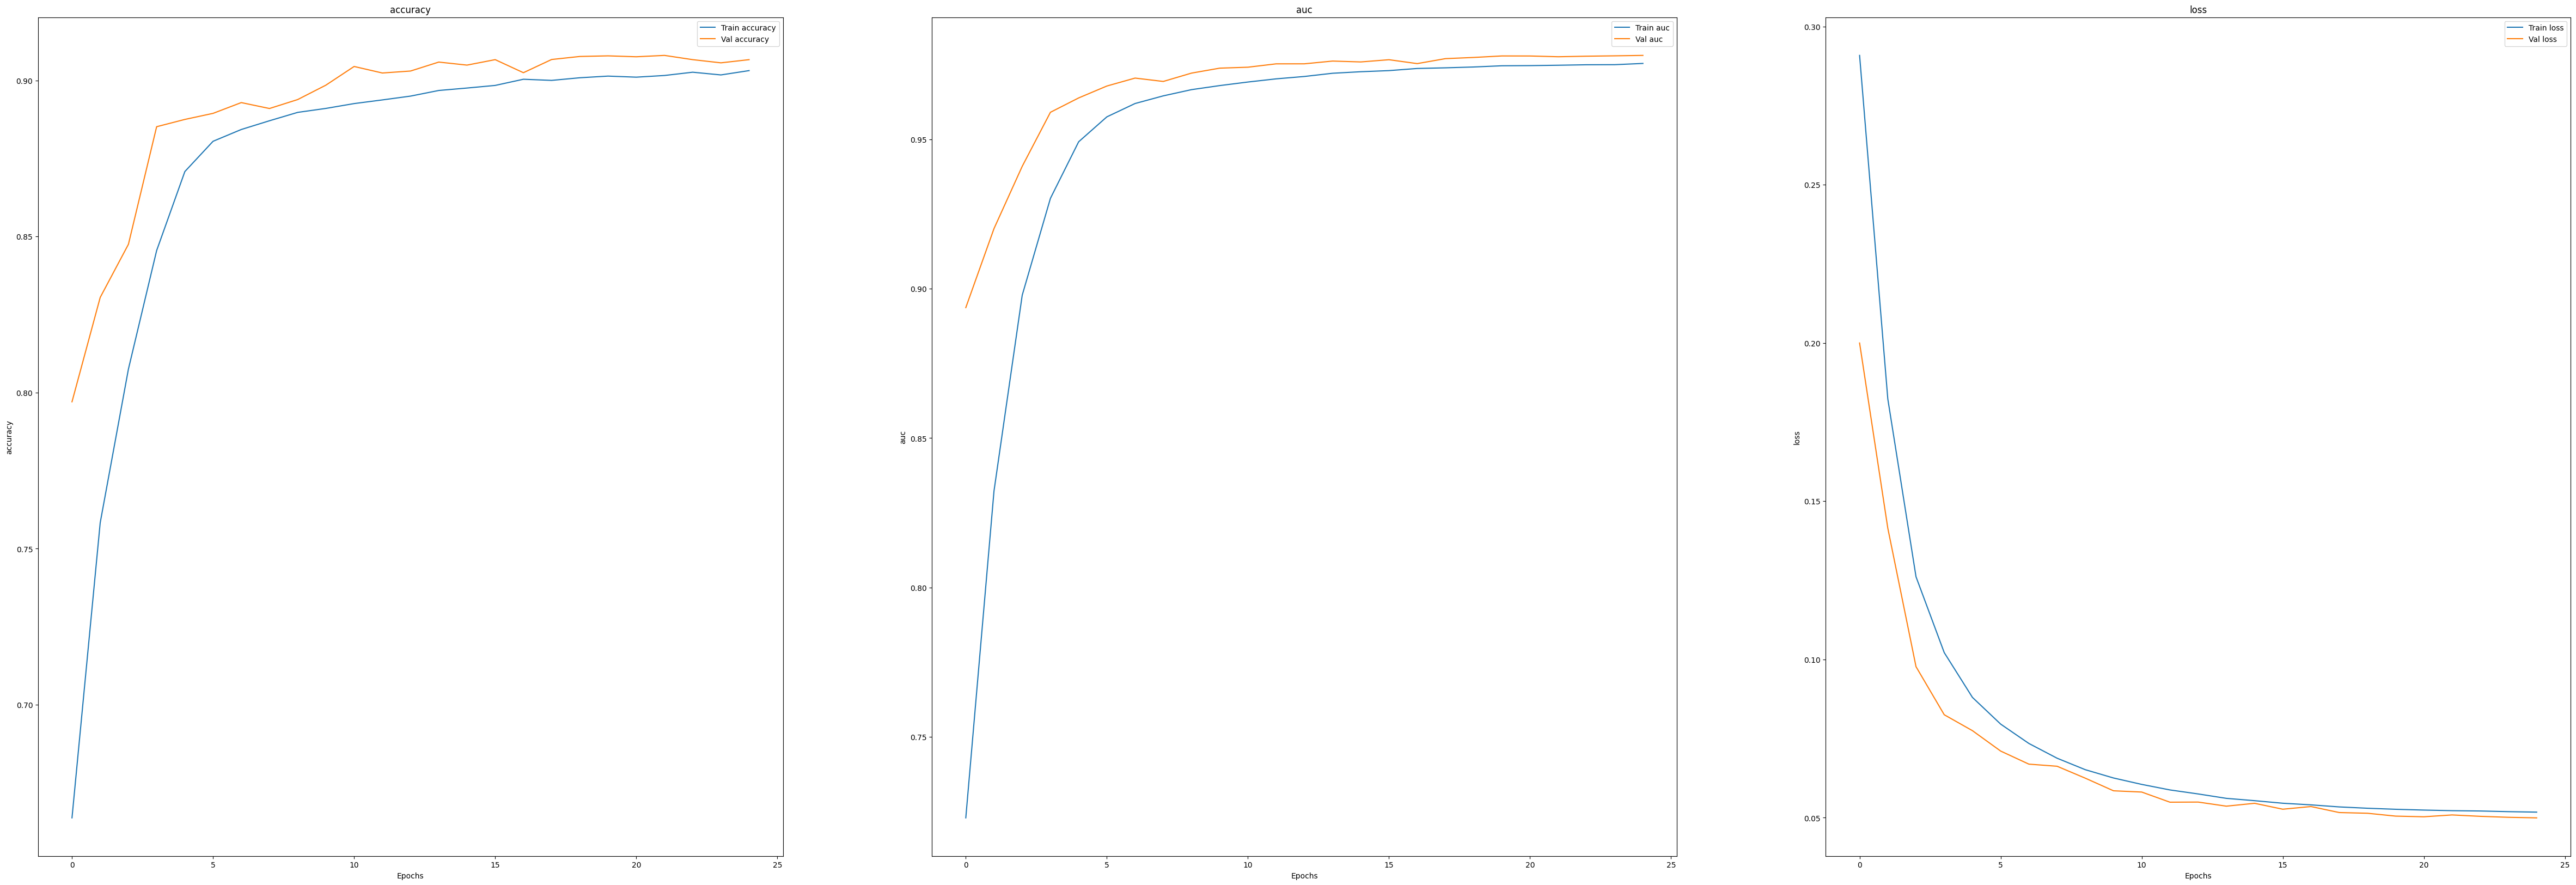

In [29]:
model_bin.plot_training_history(history_bin)

1568/1568 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step

=== Métricas Principais ===
Acurácia: 0.8122
F1-Score: 0.7809


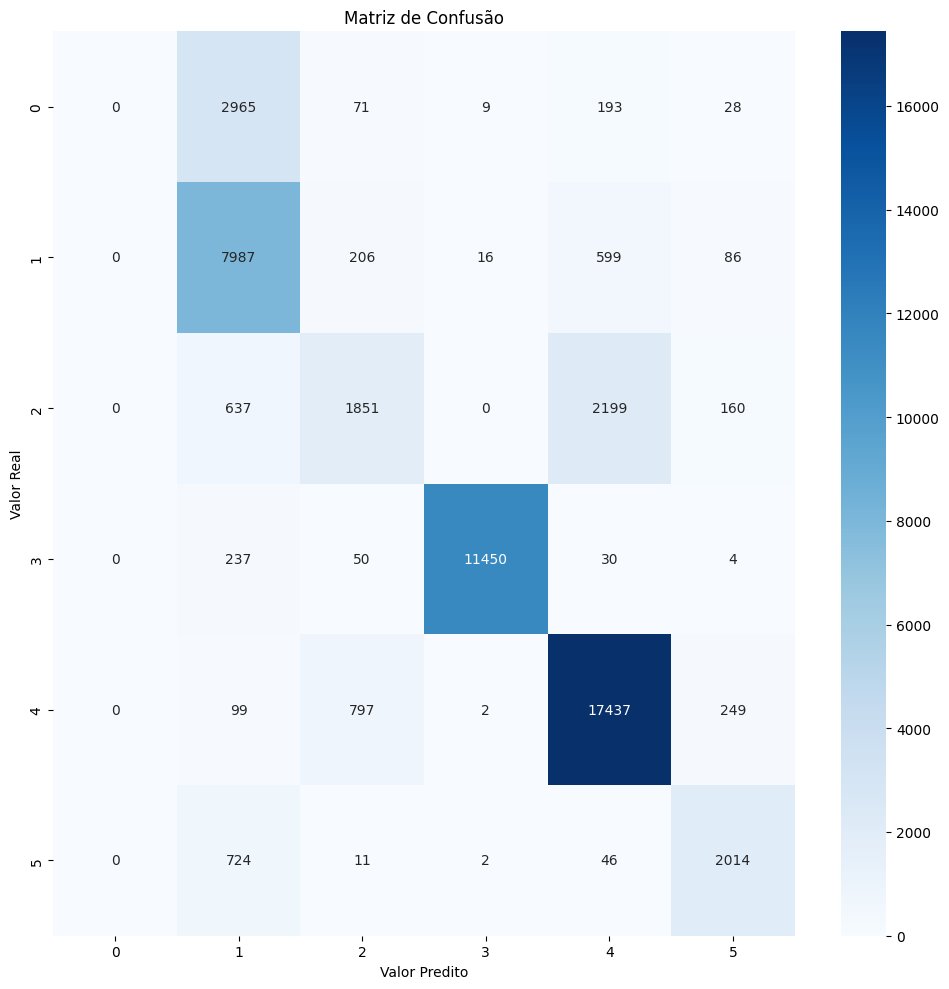

In [30]:
results = model.evaluate(X_test, y_test)
model.display_results(results)


1610/1610 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step

=== Métricas Principais ===
Acurácia: 0.9081
F1-Score: 0.9081


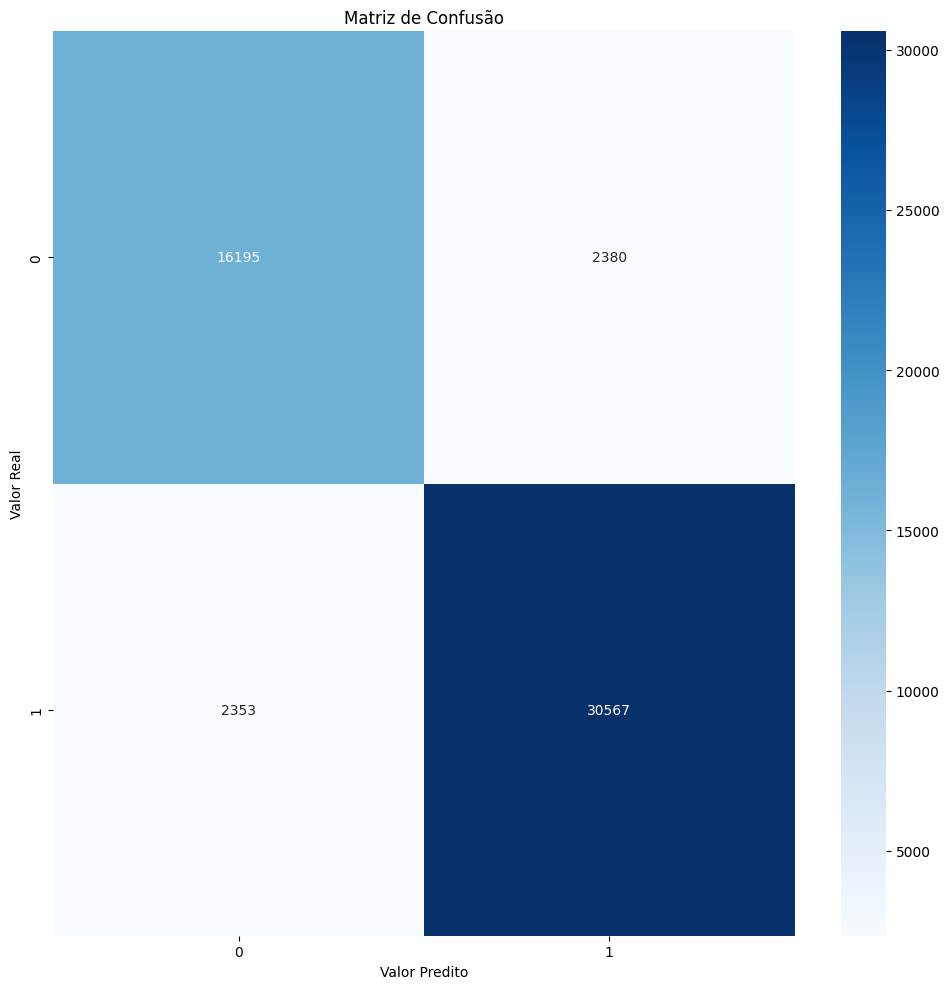

In [31]:
results_bin = model_bin.evaluate(X_test_bin,y_test_bin)
model_bin.display_results(results_bin)